# Manual Tuning SHAP comparison

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printe
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 

In [3]:
module_path = os.path.abspath(os.path.join('..'))
# Relative imports
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from utils.setup import SetupDiagnostics
from utils.variable import Variable_Lev_Metadata


In [5]:
import shap
from pathlib import Path
import pickle
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
import itertools

## Declarations

In [52]:
PROJECT_ROOT = Path.cwd().parent.resolve()

## Functions


In [53]:
def load_pickle(d_file):
    with open(d_file, "rb") as f:
        d = pickle.load(f)
    return d


In [54]:
def load_shap_data(dir_path, v_name):
    if v_name == "tphystnd-691.39":
        idx = "1_20"
    elif v_name == "tphystnd-820.86":
        idx = "1_22"
    else:
        raise ValueError(f"Index not defined for variable {v_name}")
        
    shap_name = f"shap_{idx}.p"
    inputs_name = f"inputs_{idx}.p"
    expected_value_name = f"expected_value_{idx}.p"
    test_name = f"test_{idx}.p"
    
    shap_values = load_pickle(os.path.join(dir_path, shap_name))
    inputs = load_pickle(os.path.join(dir_path, inputs_name))
    expected_value = load_pickle(os.path.join(dir_path, expected_value_name))
    test = load_pickle(os.path.join(dir_path, test_name))
    
    return shap_values, inputs, expected_value, test
                                          

In [55]:
def get_setup(setup_file):
    setup = SetupDiagnostics(["-c", setup_file])
    return setup

In [56]:
def generate_input_vars(setup):
    inputs_list = list()
    for spcam_var in setup.spcam_inputs:
        if spcam_var.dimensions == 3:
            for level, _ in setup.parents_idx_levs:
                # There's enough info to build a Variable_Lev_Metadata list
                # However, it could be better to do a bigger reorganization
                var_name = f"{spcam_var.name}-{round(level, 2)}"
                inputs_list.append(Variable_Lev_Metadata.parse_var_name(var_name))
        elif spcam_var.dimensions == 2:
            var_name = spcam_var.name
            inputs_list.append(Variable_Lev_Metadata.parse_var_name(var_name))
    return sorted([p for p in inputs_list], key=lambda x: setup.input_order_list.index(x),)

In [63]:
def get_features_feature_names(nn_inputs, setup):
    input_vars = generate_input_vars(setup)
    
    idx_input =  [(i, str(input_vars[i])) for i in nn_inputs]
    
    feature_names = [el[1] for el in idx_input]
    features = [el[0] for el in idx_input]
    
    return features, feature_names
    

In [64]:
def get_shap_explanation(config, shap_path, v_name):
    shap_values, inputs, expected_value, test = load_shap_data(shap_path, v_name)
    
    setup = get_setup(config)
    features, feature_names = get_features_feature_names(inputs, setup)
        
    exp = shap.Explanation(shap_values[0], 
                           base_values=expected_value, 
                           data=test[:, inputs], 
                           feature_names=feature_names)
    return exp


In [65]:
def plot_shap(exp, save_path, v_name, max_display=20):
    plt.close() # close any previous active plots
    
    num_features = exp.values.shape[1]
    
    # Beeswarm plots
    # The beeswarm plot is designed to display an information-dense summary of how the top features 
    # in a dataset impact the model’s output. Each instance the given explanation is represented
    # by a single dot on each feature fow. The x position of the dot is determined by the SHAP 
    # value of that feature,and dots “pile up” along each feature row to show density. 
    # Color is used to display the original value of a feature. 
    for display in [max_display, num_features]:
        shap.plots.beeswarm(exp, order=exp.abs.mean(0), max_display=display, show=False) # color=plt.get_cmap("cool"),

        fig_name = f"beeswarm_{v_name}_display_{display}.png"
        plt.savefig(os.path.join(save_path, fig_name), bbox_inches='tight')
        plt.close()
        print(f"\nSaved beeswarm plot {fig_name}.")

        shap.plots.beeswarm(exp.abs, color="shap_red", max_display=display, show=False)

        fig_name = f"beeswarm_abs_{v_name}_display_{display}.png"
        plt.savefig(os.path.join(save_path, fig_name), bbox_inches='tight')
        plt.close()

        print(f"\nSaved absolute value beeswarm plot {fig_name}.")

        # Bar plot
        # Passing a matrix of SHAP values to the bar plot function creates a global feature importance plot, 
        # where the global importance of each feature is taken to be the mean absolute value for that 
        # feature over all the given samples.
        shap.plots.bar(exp, max_display=display, show=False)

        fig_name = f"bar_{v_name}_display_{display}.png"
        plt.savefig(os.path.join(save_path, fig_name), bbox_inches='tight')
        plt.close()
        print(f"\nSaved absolute value beeswarm plot {fig_name}.\n")



## SHAP plots for CausalSingleNN and SingleNN

In [87]:
var_name = "tphystnd-691.39" # tphystnd-691.39, tphystnd-820.86

In [88]:
causal_nn_config  = os.path.join(PROJECT_ROOT, "output_castle/eval_nando/causal_single_nn/cfg_causal_single_nn_diagnostics.yml")
causal_nn_shap_path = os.path.join(PROJECT_ROOT, "output_castle/eval_nando/causal_single_nn/plots_offline_evaluation/shap/range-all_samples-1000_none")

single_nn_config = os.path.join(PROJECT_ROOT, "output_castle/eval_nando/single_nn/cfg_single_nn_diagnostics.yml")
single_nn_shap_path = os.path.join(PROJECT_ROOT, "output_castle/eval_nando/single_nn/plots_offline_evaluation/shap/range-all_samples-1000_none",)


In [89]:
causal_exp = get_shap_explanation(causal_nn_config, causal_nn_shap_path, var_name)

save_path = os.path.join(causal_nn_shap_path, "plots")
Path(save_path).mkdir(parents=True, exist_ok=True)

plot_shap(causal_exp, save_path, var_name, max_display=20)


Saved beeswarm plot beeswarm_tphystnd-691.39_display_20.png.

Saved absolute value beeswarm plot beeswarm_abs_tphystnd-691.39_display_20.png.

Saved absolute value beeswarm plot bar_tphystnd-691.39_display_20.png.


Saved beeswarm plot beeswarm_tphystnd-691.39_display_67.png.

Saved absolute value beeswarm plot beeswarm_abs_tphystnd-691.39_display_67.png.

Saved absolute value beeswarm plot bar_tphystnd-691.39_display_67.png.



In [90]:
single_exp = get_shap_explanation(single_nn_config, single_nn_shap_path, var_name)

save_path = os.path.join(single_nn_shap_path, "plots")
Path(save_path).mkdir(parents=True, exist_ok=True)

plot_shap(single_exp, save_path, var_name, max_display=20)


Saved beeswarm plot beeswarm_tphystnd-691.39_display_20.png.

Saved absolute value beeswarm plot beeswarm_abs_tphystnd-691.39_display_20.png.

Saved absolute value beeswarm plot bar_tphystnd-691.39_display_20.png.


Saved beeswarm plot beeswarm_tphystnd-691.39_display_94.png.

Saved absolute value beeswarm plot beeswarm_abs_tphystnd-691.39_display_94.png.

Saved absolute value beeswarm plot bar_tphystnd-691.39_display_94.png.



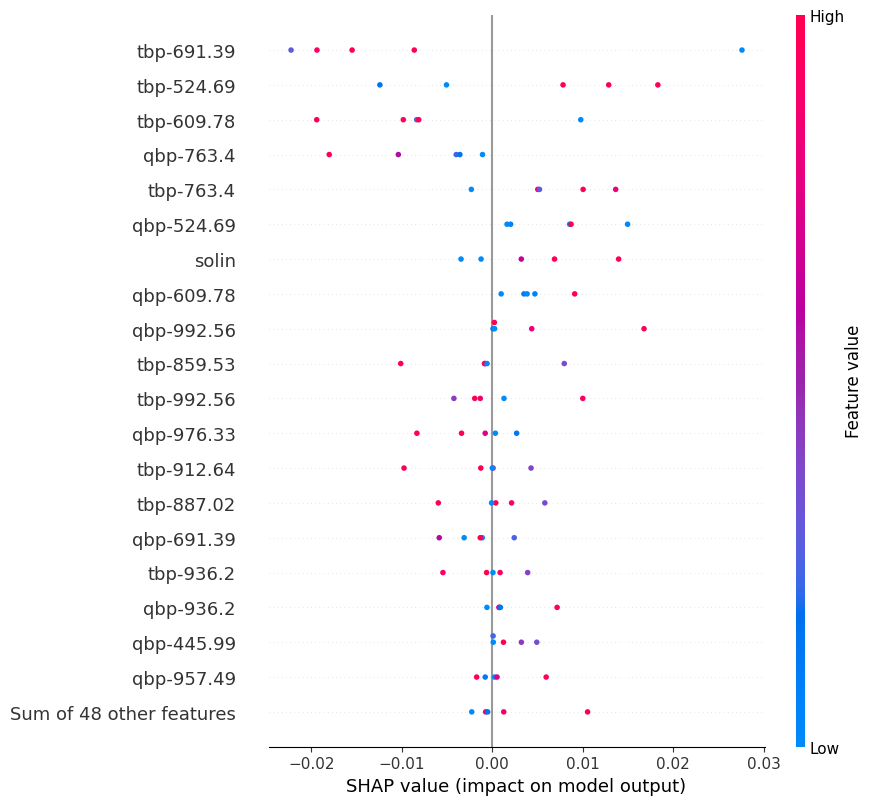

In [28]:
shap.plots.beeswarm(causal_exp, order=causal_exp.abs.mean(0), max_display=20, show=False) # color=plt.get_cmap("cool"),

# Different ordering
#shap.plots.beeswarm(causal_exp, order=causal_exp.abs.max(0), max_display=20, show=False) # color=plt.get_cmap("cool"),


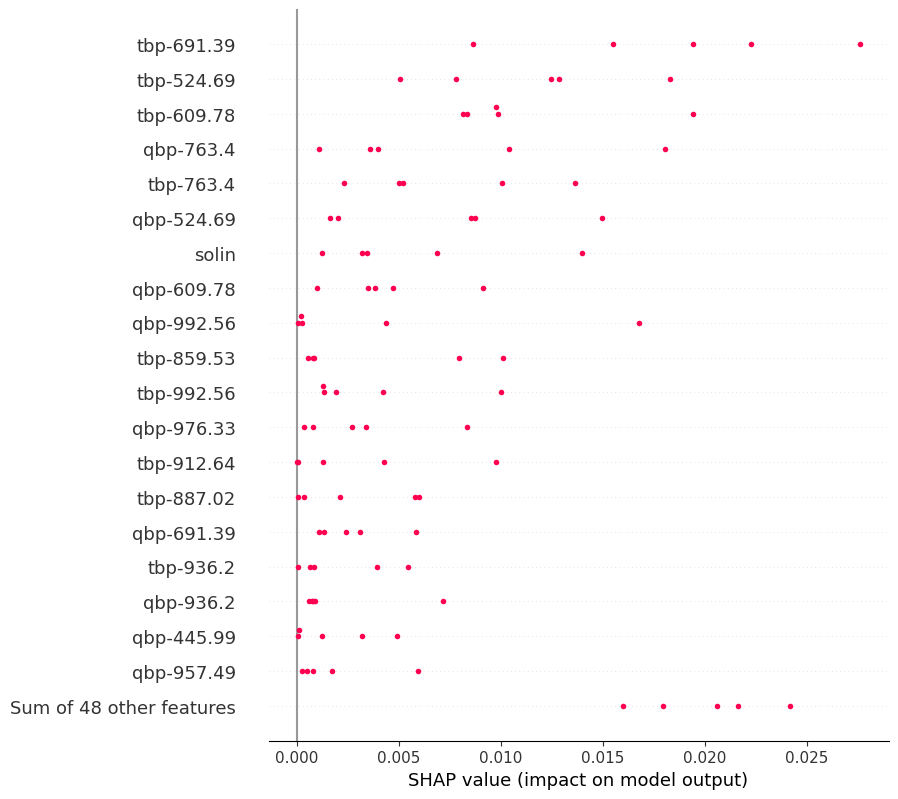

In [31]:
plt.close()
shap.plots.beeswarm(causal_exp.abs, color="shap_red", max_display=20, show=False)

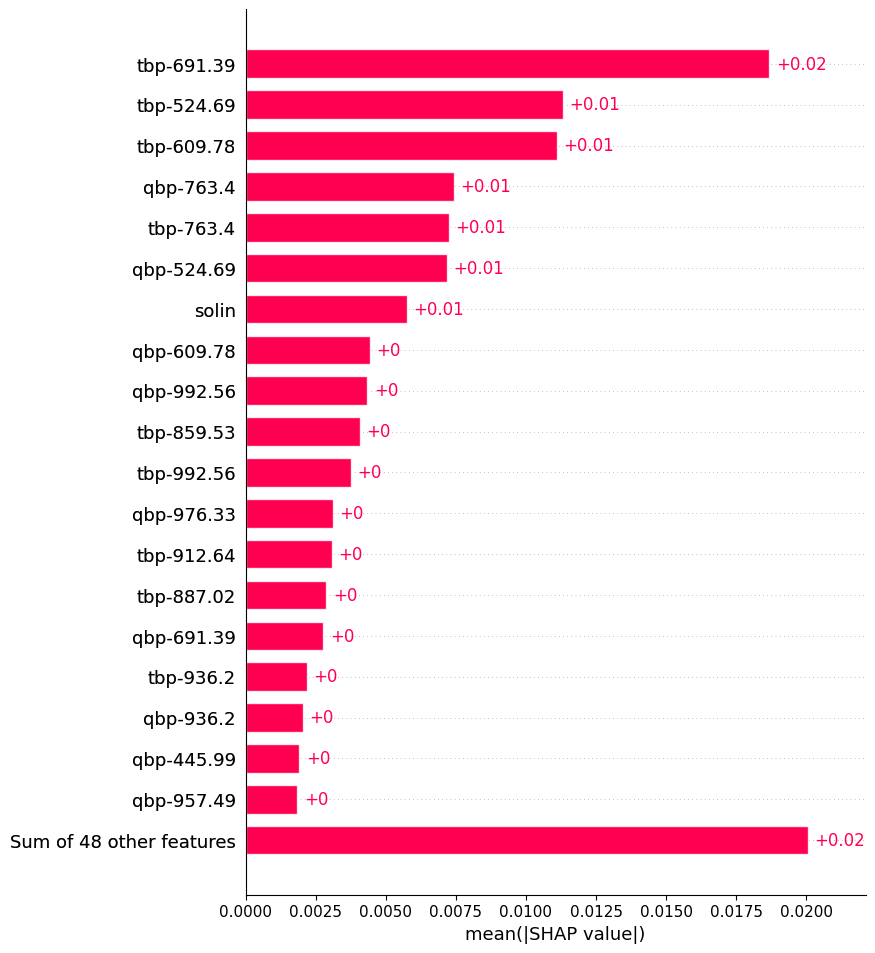

In [32]:
# Passing a matrix of SHAP values to the bar plot function creates a global feature importance plot, 
# where the global importance of each feature is taken to be the mean absolute value for that 
# feature over all the given samples.
plt.close()
shap.plots.bar(causal_exp, max_display=20, show=False)

## SHAP Plots for Manual Tunign

In [80]:
# Set tuning parameters
lambda_prediction =[1, 10, 100, 1000, 10000] #[1, 2, 4, 8, 10]
lambda_sparsity = [1.0] #[0.1, 0.5, 1.0]

# Set base directory for config files and inputs/outputs list files
base_dir = os.path.join(PROJECT_ROOT, "output_castle", "manual_tuning_tphystnd_691.39_v3-test2") # manual_tuning_tphystnd_691.39_v3-test2, manual_tuning_tphystnd_820.86_v3
tuning_models = ["castle_adapted_big_notears"]#,
                # "castle_adapted_small_notears", "castle_adapted_small_dagma", "castle_adapted_big_dagma"] 
config_name = "cfg_castle_adapted.yml"

var_name = "tphystnd-691.39"  # tphystnd-691.39, tphystnd-820.86

max_display = 20 # tphystnd-691.39 20, tphystnd-820.86 22

In [73]:
# Shap evaluation paramters
shap_dir = "range-all_samples-1000_none"

In [76]:
def run_shap_plots_for_tuning_model(model_tuned):
    t_init_total = time.time()
    
    for p, s in itertools.product(lambda_prediction, lambda_sparsity):
        params_dir = f"lambda_pred_{p}-lambda_sparsity_{s}"

        cfg = os.path.join(base_dir, model_tuned, params_dir, config_name)
        shap_path = os.path.join(base_dir, "evaluation", model_tuned, params_dir, "shap", shap_dir)
        output_path = os.path.join(shap_path, "plots")
        Path(output_path).mkdir(parents=True, exist_ok=True)
        
        print(f"\n\n{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} " + \
              f"--- Plotting SHAP value plots for model {model_tuned} for parameters " + \
              f"lambda_prediciton={p}, lambda_sparsity={s}")
        t_init = time.time()
        
        exp = get_shap_explanation(cfg, shap_path, var_name)
        plot_shap(exp, output_path, var_name, max_display=max_display)
        
        t_end = datetime.timedelta(seconds=time.time() - t_init)
        print(f"\n{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} " + \
              f"--- Finished for model {model_tuned} for parameters " + \
              f"lambda_prediciton={p}, lambda_sparsity={s}. Elapsed time: {t_end}")
        
    t_end_total = datetime.timedelta(seconds=time.time() - t_init_total)
    print(f"\n\n{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} " + \
          f"--- Finished all SHAP plots for {model_tuned}. Total elapsed time: {t_end_total}\n\n")

In [77]:
t_start = time.time()
for m in tuning_models:
    run_shap_plots_for_tuning_model(m)

t_finish =  datetime.timedelta(seconds=time.time() - t_start)

print(f"\n\n{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} " + \
      f"------ Finished. Total elapsed time: {t_finish}\n\n")



2023-11-23 14:23:59 --- Plotting SHAP value plots for model castle_adapted_big_notears for parameters lambda_prediciton=1, lambda_sparsity=1.0


FileNotFoundError: [Errno 2] No such file or directory: '/work/bd1179/b309247/pycharm_projects/iglesias-suarez2yxx_spuriouslinks/output_castle/manual_tuning_tphystnd_820.86_v3/evaluation/castle_adapted_big_notears/lambda_pred_1-lambda_sparsity_1.0/shap/range-all_samples-1000_none/shap_1_22.p'